### project navigation

before coming to this notebook i recommend to see how the dataset was prepared for training.

- 📂 [Dataset Preparation](01_dataset_preparation.ipynb)


## **Loading the Image Dataset**

After spliting  the directory dataset into train,val,test. 
the next step is to load images from disk into a format that a CNN can understand.
Unlike CSV files (which can be loaded entirely into memory)

but image datasets:
- Are large
- Cannot be loaded all at once
- Must be read batch by batch

For this reason, we use **Keras image data generators.**

In [1]:
# step 1: imports

from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# tensorflow.keras provides utilities to work with image datasets
# ImageDataGenerator helps load images efficiently from folders


In [2]:
# create data generators

# Note: Training and validation use separate generators

train_datagen = ImageDataGenerator( 
    rescale=1./255
)
# Original pixel values are in the range 0–255 ,CNNs work better when values are in 0–1 so we rescaled(normalization).
val_datagen = ImageDataGenerator(
    rescale=1./255
)

# Why we need data generators
# 1.They read images from disk in batches
# 2.They automatically:
# - resize and normalize images.
# - convert them to numerical arrays(rows and columns format).
# - assign labels based on folder names.
# note that : folder names are used as labels snice these are not numbers but strings so  one hot encoded automatically done. 

## **Load training images from our directory dataset**

**reminder** : our dataset is structered like this, where each training ,test,val folders conatains 10 tomato disease sub folders which have there related image files.
- dataset/
-  ├── train/    
-  ├── val/       
-  └── test/     



In [3]:
# 📁 1. Explore dataset structure

import os

os.listdir("dataset")

# this is like df.columns

['test', 'train', 'val']

In [4]:
# See class names (labels) of training 

os.listdir("dataset/train")

# just like df['target'].unique()
# we can see the 10 tomatoe disease folders. note that 🪬 : model uses these folders names as labels.

['Tomato___Target_Spot',
 'Tomato___Late_blight',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Leaf_Mold',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Septoria_leaf_spot']

---
### VIEW an **leaf image** 
Just like looking at first row in CSV.

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

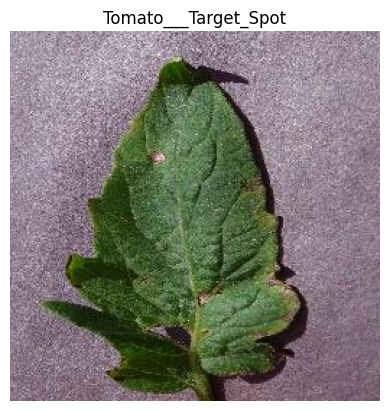

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import os

cls = os.listdir("dataset/train")[0]
img_name = os.listdir(f"dataset/train/{cls}")[0]

img_path = f"dataset/train/{cls}/{img_name}"

img = Image.open(img_path)

plt.imshow(img)
plt.title(cls)
plt.axis("off")


In [6]:
# 3. Count images per class (VERY USEFUL) 
# This is the image version of value_counts().

import os

for cls in os.listdir("dataset/train"):
    cls_path = os.path.join("dataset/train", cls)
    print(cls, ":", len(os.listdir(cls_path)))


# you can understand class balance

Tomato___Target_Spot : 982
Tomato___Late_blight : 1336
Tomato___Tomato_mosaic_virus : 261
Tomato___Leaf_Mold : 666
Tomato___Bacterial_spot : 1488
Tomato___Early_blight : 700
Tomato___healthy : 1113
Tomato___Tomato_Yellow_Leaf_Curl_Virus : 3749
Tomato___Spider_mites Two-spotted_spider_mite : 1173
Tomato___Septoria_leaf_spot : 1239


In [7]:
# Total images in each split
# Like checking df.shape.

def count_images(split):
    total = 0
    for cls in os.listdir(f"dataset/{split}"):
        total += len(os.listdir(f"dataset/{split}/{cls}"))
    return total

print("Train images:", count_images("train"))
print("Val images:", count_images("val"))
print("Test images:", count_images("test"))


Train images: 12707
Val images: 2719
Test images: 2734


## load training images.

In [8]:
train_data = train_datagen.flow_from_directory(    
    directory="dataset/train",              # parameter : directory → path to training images
    target_size=(128, 128),                 # target_size → all images resized to 128×128
    batch_size=32,                          # batch_size → number of images loaded at a time
    class_mode="categorical"                # class_mode="categorical" → used for multi-class classification.
)

# What this step does : 
# 1. Reads images from dataset/train
# 2. Uses folder names as class labels
# 3. Resizes all images to the same size
# 4. Loads images in batches (not all,32 images at once)

Found 12707 images belonging to 10 classes.


---
## how Keras “understands” your directory dataset.

What Keras sees on disk (your folders)
Your dataset on disk looks like this:

- dataset/train/
-  ├── Tomato___Early_blight/
-  │    ├── img1.jpg
-  │    ├── img2.jpg
-  │    └── ...
-  ├── Tomato___Late_blight/
-  │    ├── img3.jpg
-  │    └── ...
-  └── Tomato___healthy/
-       ├── img4.jpg
-       └── ...

to us, this are folders and images.
To Keras, this is raw input that must be converted into numbers + labels.

---
First thing Keras does: read folder names
When you run: **flow_from_directory("dataset/train")**

Keras does this internally:
- Looks inside dataset/train/
- Finds all subfolder names
- Sorts them alphabetically
- Assigns numbers to them

Example:

- Tomato___Early_blight  → 0
- Tomato___Late_blight   → 1
- Tomato___healthy       → 2
---
👉 These numbers are called **class labels.**

You can see them with:


In [9]:
train_data.class_indices


{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

---
2. Second thing: scan images inside each folder

Now Keras goes folder by folder:
- Enters Tomato___Bacterial_spot
- Reads all .jpg/.png files
- Assigns **label 0** to every image inside this bacterial_spot folder. as from above output we can see clearly keras assigns label 0 for this folder bacterial spot disease.
- Same for other folders assigns there respective labels.

So internally, Keras builds something like this:

|Image path                                   | Label
|---------------------------------------------| -----
|dataset/train/Tomato___Early_blight/img1.jpg |    1
|dataset/train/Tomato___Early_blight/img2.jp  |    1
|dataset/train/Tomato___Late_blight/img3.jpg  |    2
|dataset/train/Tomato___healthy/img4.jpg      |    9

---
3. Third thing: convert images to numbers
Each image file is converted into a matrix of numbers.

---
4. Fourth thing: create batches(same idea as in Neural Networks)
Instead of loading everything at once, Keras groups data into batches.

---
### Final mental picture
so Even though your data is stored as folders and images,

Keras internally treats it like a tabular format:

| Image (numbers) | Label (number) |
| --------------- | -------------- |
| pixel matrix    | 0              |
| pixel matrix    | 0              |
| pixel matrix    | 1              |
| pixel matrix    | 2              |
| ...             | ...            |

---
**one sentence to remeber :**

"flow_from_directory" converts folder names into labels and image files into numerical tensors(matrixes) automatically.





## Load the validation dataset
Why validation data is loaded separately : 
- Validation images are never used for training
- They are used to monitor model performance during training.

In [10]:
val_data = val_datagen.flow_from_directory(
    directory="dataset/val",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical"
)


Found 2719 images belonging to 10 classes.


## Load the test dataset

Test data is used only once for final evaluation of the model


In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    directory="dataset/test",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False             # shuffle parameter → decides the order of images that are read during loading
)

Found 2734 images belonging to 10 classes.


---
####  Why we usually keep shuffle=True for TRAIN
 For training:
-  Model should not see images in the same order every epoch
- Random order improves learning and Avoids bias. so shuffel = true by default for train and validation
---
#### Why we set shuffle=False for TEST (important)
For test data, we want:
- Fixed image order
- Predictions aligned with true labels so our evaluation metrics results are trustable.

---
What Keras does internally (important)
When you load test data:

Keras internally creates:
- test_data.filenames → list of image paths
- test_data.classes → list of true labels (numbers)
- Model predictions come in the same order
-  Everything stays aligned.

just conceptual visuval :

| Image order | True label   | Model prediction |
| ----------- | ------------ | ---------------- |
| Image 1     | Healthy      | Healthy          |
| Image 2     | Early blight | Early blight     |
| Image 3     | Late blight  | Healthy          |
| …           | …            | …                |

so model can cal actual vs predicted, we will see correct evaluation results.

---

#### What breaks when shuffle=True 
What happens:
- Images are randomly reordered
- Labels are still attached internally
- But the order changes 
- Predictions no longer align with your expected image order

---

## Next Steps After Loading the Dataset
***Overall pipeline :***
1. *Define the CNN model*
2. *Compile the model*
3. *Train the model*
4. *Evaluate on test data*
---

### ***Step 1:*** Build the CNN Model
**Why we need a CNN model ?**

images are not just pixel numbers — they have a spatial structure which means position of pixels and their neighboring relationships matter.

#### What makes image data special?
**Images contain:**
1. Spatial information (height × width × channels)

2. Local patterns, such as:
- edges
- spots
- veins
- textures

A normal Neural Network (Dense/MLP) flattens the image and loses spatial information.
A CNN is designed specifically to preserve and learn from this structure.

---
### How a CNN Understands Images
**1. Convolution Layers – Learn local visual patterns**
- Small filters (kernels) slide over the image
- Each filter detects a specific pattern like spots,textures,edges, etc

Early convolution layers learn simple features:
- edges
- color contrasts
- small spots
- leaf veins

These features are learned automatically during training.

---
**2. Deeper Convolution Layers – Learn complex patterns**

As we go deeper:
- Simple features combine to form higher-level patterns, The model starts recognizing:
- disease-specific textures
- infected regions on leaves

These layers understand “what kind of disease pattern this looks like”.

---
**3. Dense (Fully Connected) Layers – Make the final decision**

 all learned features are extracted and flattened into a vector,
Dense layers analyze these features together,

Final layer predicts: *which disease class the image belongs to*

---
**In simple words:**
- *Convolution layers extract features*
- *Dense layers classify them*

In [13]:
# import required layers
# as These layers are the building blocks of a CNN.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [14]:
# Define the CNN architecture

model = Sequential()

# cnn layer 1
model.add(Conv2D(32, (3,3), activation='relu',  # this layer applies 32 filters each of size 3x3 
                 input_shape=(128,128,3)))      # each filter slides on image size of 128x128X3,these 32 filters produces 32 feature maps.      
model.add(MaxPooling2D(2,2))                    # these 32 feature maps are  applied to activation function relu independendly.             

# Max Pooling always works on feature maps AFTER ReLU, not on raw images.
# Without pooling: Feature maps are huge. leads to overfitting.
# with Pooling: Reduces size of feature maps by keeping only important ones, not the no of feature maps but size only. Makes CNN efficient
#  max pooling applied to all feature maps? i.e, If Conv layer gives 32 feature maps
# → Max pooling is applied independently to each one.



# layer 2, Now this layer recives 32 ReLU feature maps (from previous layer) as inputs and apply filters.
# Each filter in the second layer: looks at ALL 32 feature maps together combines information from all of them produces ONE new feature map
# snice this layers uses 64 filters which gives again 64 feature maps applied to relu produces outputs for next layer.
model.add(Conv2D(64, (3,3), activation='relu'))  
model.add(MaxPooling2D(2,2))

# cnn last layer 3
# this layers recives those 64 feature maps from above layer again apply filters produces new feature maps.
model.add(Conv2D(128, (3,3), activation='relu')) 

# dense layers for classification 
# final layer outputs 128 relu feature maps before giving to dense input layers they were flattened to 1d vectors.
model.add(Flatten())
model.add(Dense(128, activation='relu')) # input layer
# ecah neuron in the input layer recives the final 128 relu feature maps(extracted features) as inputs.
model.add(Dropout(0.5)) # drops 50% neurons randomly, so neurons cannot memorize data.
model.add(Dense(10, activation='softmax')) # output layer with 10 neurons with softmax as activation function for muticlassification.
# snince they were 10 classes so output layer must be 10 neurons.

/opt/anaconda3/envs/tf310/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


---
### ⚙️ Step 2: Compile the Model
Why compilation is needed
Compilation tells the model:
- How to learn → optimizer
- What to minimize → loss function
- What to measure → metrics

In [15]:
model.compile(
    optimizer='adam',                # gradient descent 
    loss='categorical_crossentropy', # loss function of multiclassification softmax.
    metrics=['accuracy']
)


---
### training
Training allows the model to:
- adjust weights
- learn disease-specific patterns

In [16]:
history = model.fit(
    train_data,
    validation_data=val_data, 
    epochs=10
)


Epoch 1/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 67s 166ms/step - accuracy: 0.5979 - loss: 1.2054 - val_accuracy: 0.7742 - val_loss: 0.6617
Epoch 2/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 68s 171ms/step - accuracy: 0.7717 - loss: 0.6757 - val_accuracy: 0.8547 - val_loss: 0.4390
Epoch 3/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 71s 178ms/step - accuracy: 0.8059 - loss: 0.5718 - val_accuracy: 0.8650 - val_loss: 0.4102
Epoch 4/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 70s 176ms/step - accuracy: 0.8495 - loss: 0.4374 - val_accuracy: 0.8488 - val_loss: 0.4962
Epoch 5/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 73s 182ms/step - accuracy: 0.8704 - loss: 0.3800 - val_accuracy: 0.8632 - val_loss: 0.4105
Epoch 6/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 74s 185ms/step - accuracy: 0.8931 - loss: 0.3160 - val_accuracy: 0.9077 - val_loss: 0.3188
Epoch 7/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 75s 190ms/step - accuracy: 0.8987 - loss: 0.2935 - val_accuracy: 0.8617 - val_loss: 0.4197
Epoch 8/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 72s 182ms/step - accuracy: 0.9163 - loss: 0

---
### **save** the trained model 🔥
used for later deployment

In [29]:
model.save("model/tomato_model.h5")


---
## Checking Overfitting Using Learning Curves
Overfitting happens when:
- The model performs very well on training data
- But performs poorly on validation data

This means the model has memorized training images instead of learning general patterns.

---
Learning curves show:
- How training accuracy/loss changes over epochs
- How validation accuracy/loss changes over epochs

By comparing them, we can visually detect overfitting.

---
note that we saved our training results in object history.

The history object automatically stores:
- training accuracy
- validation accuracy
- training loss
- validation loss

We will use this information to create plots.

In [17]:
# We use matplotlib to visualize training behavior over epochs.
import matplotlib.pyplot as plt


### Plot Accuracy Curves
What this plot shows
1. Blue line → training accuracy
2. Orange line → validation accuracy
3. X-axis → epochs
4. Y-axis → accuracy


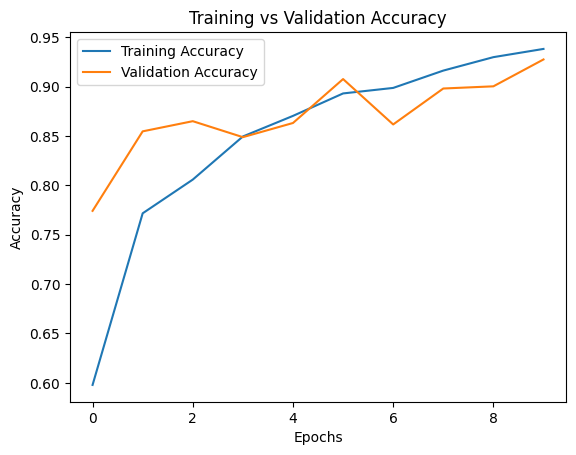

In [18]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.title('Training vs Validation Accuracy')
plt.show()


### Plot Loss Curves
loss is more reliable than accuracy in revealing overfitting

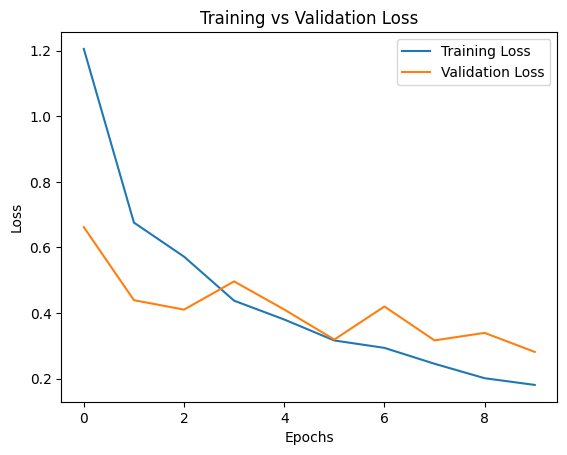

In [19]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Training vs Validation Loss')
plt.show()


---
### **Overfitting Analysis** Using Learning Curves
The learning curves show training and validation accuracy and loss across epochs.
Both training and validation accuracy increase steadily and remain close to each other, indicating good generalization.
Similarly, training and validation loss decrease together without a sustained increase in validation loss.
Although minor fluctuations are observed in the validation curves, this behavior is normal and does not indicate overfitting.
Overall, the model does not show signs of overfitting and generalizes well to unseen validation images.


next its time to test our model to see the honest performance 
1.  Use the trained model
2. Evaluate it on the test dataset
3. Get test loss and test accuracy

### **test evaluation**

In [21]:
test_loss, test_accuracy = model.evaluate(test_data)


86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9250 - loss: 0.2349


In [22]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.2349
Test Accuracy: 0.9250


---
### **model daigniosis**
- The model correctly predicts ~92% of unseen tomato leaf images
- Test accuracy ≈ Validation accuracy 
- This confirms:No overfitting and Good generalization.
---
### **Test Report**
The trained CNN was evaluated on a  test dataset to measure its real-world performance on unseen tomato leaf images. these images not seen during training or validation.
The test accuracy closely matches the validation accuracy, indicating that the model generalizes well to unseen data and does not suffer from overfitting.

---

accuracy alone is not enough to judge the performance, as
Accuracy tells us Overall correctness
But it does NOT tell us:
- Which diseases are confused with others
- Which class the model struggles with
- Per-class performance

A confusion matrix answers these questions.

---

### **Confusion Matrix** (Detailed Class-wise Evaluation)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



In [24]:
# 1. fristly Get true labels from test data
true_labels = test_data.classes

# What this does
# Extracts actual class labels of test images
# These labels come from folder names

In [25]:
# Get model predictions on test data
pred_probs = model.predict(test_data)
pred_labels = np.argmax(pred_probs, axis=1)



# What this does
# Model predicts probabilities for each class
# argmax converts probabilities → class index


86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step


In [26]:
# create confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Now cm is a 10 × 10 matrix (since you have 10 tomato classes).

In [27]:
# get class names for human readablity on plot
class_names = list(test_data.class_indices.keys())


---
### Plot the **confusion matrix**
What this plot shows
- Diagonal cells → correct predictions
- Off-diagonal cells → misclassifications(errors)



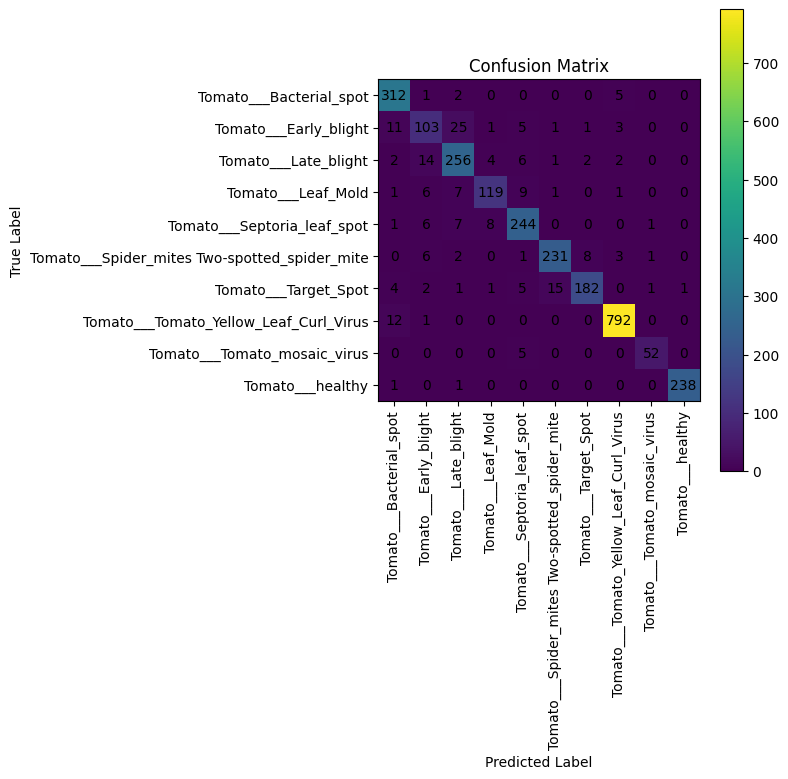

In [28]:
plt.figure(figsize=(8, 8))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(range(len(class_names)), class_names, rotation=90)
plt.yticks(range(len(class_names)), class_names)
plt.colorbar()

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


---
#### **Overall observation**
- The diagonal is very strong (dark/high numbers)
- Off-diagonal values are small

This means The model classifies most diseases correctly.
Errors are limited and biologically reasonable Overall performance is very good.

---
**Class-wise interpretation**

1. Tomato___Tomato_Yellow_Leaf_Curl_Virus

792 correct predictions
Almost no confusion with other classes.

---
2. Tomato___healthy

238 correctly classified
Almost zero confusion. The model clearly distinguishes healthy vs diseased leaves
This is a very positive result for real-world use.

---
3. Early blight ↔ Late blight
- Some Early blight images predicted as Late blight
- Some Late blight images predicted as Early blight

These diseases look visually similar
Even humans confuse them sometimes
This is not a model failure, but a biological similarity issue.

---
4. Leaf Mold ↔ Septoria leaf spot

Minor confusion between these two, this is also reasonable biological error
becuase both share some same disease patterns like Multiple small spots,
Dense infection across the leaf,
Often appear on older leaves. so this is normal and accepted as its an biological similarity issue.

---
5. Bacterial spot, Target Spot, Spider mites
- High diagonal values
- Few misclassifications
as these diseases have textures patterns more which means The model handles texture-based diseases well

---
overall The model
Generalizes well,
Has no major bias toward any class,
Makes errors mainly between visually similar diseases which means our model is not randomly guessing.

### **🔍 Confusion Matrix Analysis**
The confusion matrix provides a detailed, class-wise evaluation of the CNN model on the test dataset.
Strong diagonal values indicate that most tomato disease classes are correctly classified.
The model shows excellent performance for diseases such as Tomato Yellow Leaf Curl Virus and Healthy leaves, with minimal confusion.
Misclassifications mainly occur between visually similar diseases such as Early Blight and Late Blight, or Leaf Mold and Septoria, share highly similar visual symptoms on tomato leaves these are biologically reasonable misclassifications rather than model errors. Since CNNs rely purely on visual patterns such as color, texture, spots etc so diseases with similar visuval patterns making model to get confused.These confusions are biologically reasonable and indicate that the model is learning meaningful visual features rather than making random mistakes.

---
# 🔮 Future Work and Deployment

## 🌱 Extending to More Plant Species
In this project, only **tomato leaf images** were selected from the original PlantVillage dataset.
In future versions of this project, the same dataset reorganization pipeline can be extended to:

- Include additional plant species (e.g., potato, pepper, apple, grape)
- Handle multi-plant classification instead of a single plant
- Train a unified model capable of recognizing diseases across different crops

The current directory-based structure is scalable and supports easy expansion.

---

## 🚀 Model Deployment
The trained tomato disease classification model has been deployed using **Streamlit**.

Key deployment highlights:
- Users can upload a tomato leaf image through a web interface
- The model predicts the disease class in real time
- Prediction confidence is displayed for better interpretability
- Disease descriptions and management tips are shown for user guidance

This deployment makes the model accessible to non-technical users such as farmers, students, and researchers.

---

## 🔁 Reproducibility and Reusability
- The dataset reorganization was performed using an automated Python script
- Once executed, the train/validation/test splits remain stable on disk
- The same splitting strategy can be reused for future datasets and plant types

---

## 📈 Future Improvements
Potential enhancements include:
- Adding data augmentation to improve generalization
- Introducing Grad-CAM visualizations for model explainability
- Deploying the application on Streamlit Cloud or Hugging Face Spaces
- Integrating mobile image capture for real-world usage

---

